# Automatic sleep staging

This notebook demonstrates how to perform automatic sleep staging of polysomnography data in YASA. For more details, make sure to read the [eLife publication](https://elifesciences.org/articles/70092).

Please install the latest version of YASA first with: `pip install --upgrade yasa`.

In [243]:
import mne
import yasa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown as markdown
from IPython.display import display
from IPython.display import Latex as latex

Functions:

In [276]:
def make_hypno (raw, evs, annot_id, event_id):
    """ Make proper hypnogram from raw data and events.

    Parameters:
    -----------
    raw : mne.io.Raw object
    evs : MNE events array
    annot_id : dict. keys are stage names in file, values are coded stage you want.
    event_id : dict. keys are stage names in file, values are stage numbers for mne.


    """
    ## What we'll need for the function
    rev_an_id = {event_id[k]:v for k,v in annot_id.items()}
    sfreq = raw.info['sfreq']
    dt = 1/sfreq
    neps = int(len(raw)/(30*sfreq))

    # Make "stage", which is a time series with the same shape as the raw eeg, but contains the sleep stage for that given point 

    stage = np.ones_like(raw.times)

    for i in range(0,len(evs)-1):
        stage[evs[i][0]:evs[i+1][0]] = evs[i+1][2]
    stage[evs[len(evs)-2][0]:] = evs[len(evs)-1][2]

    ev_headers = np.array([stage[int(i*30*sfreq)] for i in range(neps)])
    hypno = np.array([rev_an_id[i] for i in ev_headers])

    return hypno

## Data loading

The automatic sleep staging function requires that the data are loaded using the [MNE Python package](https://mne.tools/stable/index.html). For instance, if your polysomnography data are stored in the standard European Data Fomat (.edf), you can use [this function](https://mne.tools/stable/generated/mne.io.read_raw_edf.html?highlight=read_raw_edf#mne.io.read_raw_edf) to load the data into Python.

In [244]:
[[e,h]] = mne.datasets.sleep_physionet.temazepam.fetch_data(subjects=[2])

Using default location ~/mne_data for PHYSIONET_SLEEP...


In [245]:
# Let's load a nap recording, directly as an MNE Raw object
raw = mne.io.read_raw(e, preload=True, verbose=False)
print('The channels are:', raw.ch_names)
print('The sampling frequency is:', raw.info['sfreq'])
raw.set_channel_types({'EEG Fpz-Cz': 'eeg',
                        'EEG Pz-Oz': 'eeg',
                        'EOG horizontal': 'eog',
                        'EMG submental': 'emg',
                        'Marker': 'stim'})
raw

The channels are: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker']
The sampling frequency is: 100.0


/tmp/ipykernel_20108/1354156.py:5: RuntimeWarning: The unit for channel(s) Marker has changed from V to NA.
  raw.set_channel_types({'EEG Fpz-Cz': 'eeg',


<RawEDF | ST7041J0-PSG.edf, 5 x 3116000 (31160.0 s), ~118.9 MB, data loaded>

Setting specific stage ID dicts to make MNE happy:


In [278]:
annot_id={
    'Sleep stage W': 'W',
    'Sleep stage 1': 'N1',
    'Sleep stage 2': 'N2',
    'Sleep stage 3': 'N3',
    'Sleep stage 4': 'N3',
    'Sleep stage R': 'R',
    'Sleep stage ?': '?'
}

annots=mne.read_annotations(h, annot_id)
raw.set_annotations(annots, emit_warning=False)
# raw.plot(start=60, duration=60,
            #    scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7,
                            #  misc=1e-1));

event_id = {k:i for i,k in enumerate(annot_id.keys())}
event_id['Sleep stage ?'] = -1
event_id['Sleep stage 4'] = 3
event_id['Sleep stage R'] = 4

evs, stdict = mne.events_from_annotations(raw,event_id=event_id,chunk_duration=30.)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


In [280]:
hypno = make_hypno(raw, evs, annot_id, event_id)

## Sleep staging

Automatic sleep stages classification can be done since YASA 0.4.0 using the [SleepStaging](https://raphaelvallat.com/yasa/build/html/generated/yasa.SleepStaging.html#yasa.SleepStaging) class. Make sure to read the [documentation](https://raphaelvallat.com/yasa/build/html/generated/yasa.SleepStaging.html#yasa.SleepStaging), which explains how the algorithm works.

In [281]:
# We first need to specify the channel names and, optionally, the age and sex of the participant
# - "raw" is the name of the variable containing the polysomnography data loaded with MNE.
# - "eeg_name" is the name of the EEG channel, preferentially a central derivation (e.g. C4-M1). This is always required to run the sleep staging algorithm.
# - "eog_name" is the name of the EOG channel (e.g. LOC-M1). This is optional.
# - "emg_name" is the name of the EMG channel (e.g. EMG1-EMG3). This is optional.
# - "metadata" is a dictionary containing the age and sex of the participant. This is optional.
sls = yasa.SleepStaging(raw, eeg_name="EEG Fpz-Cz", metadata=dict(age=18, male=False),)

In [282]:
# Getting the predicted sleep stages is now as easy as:
y_pred = sls.predict()
y_pred = np.array(y_pred, dtype=str)

/home/taha/envs/yasa-env/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


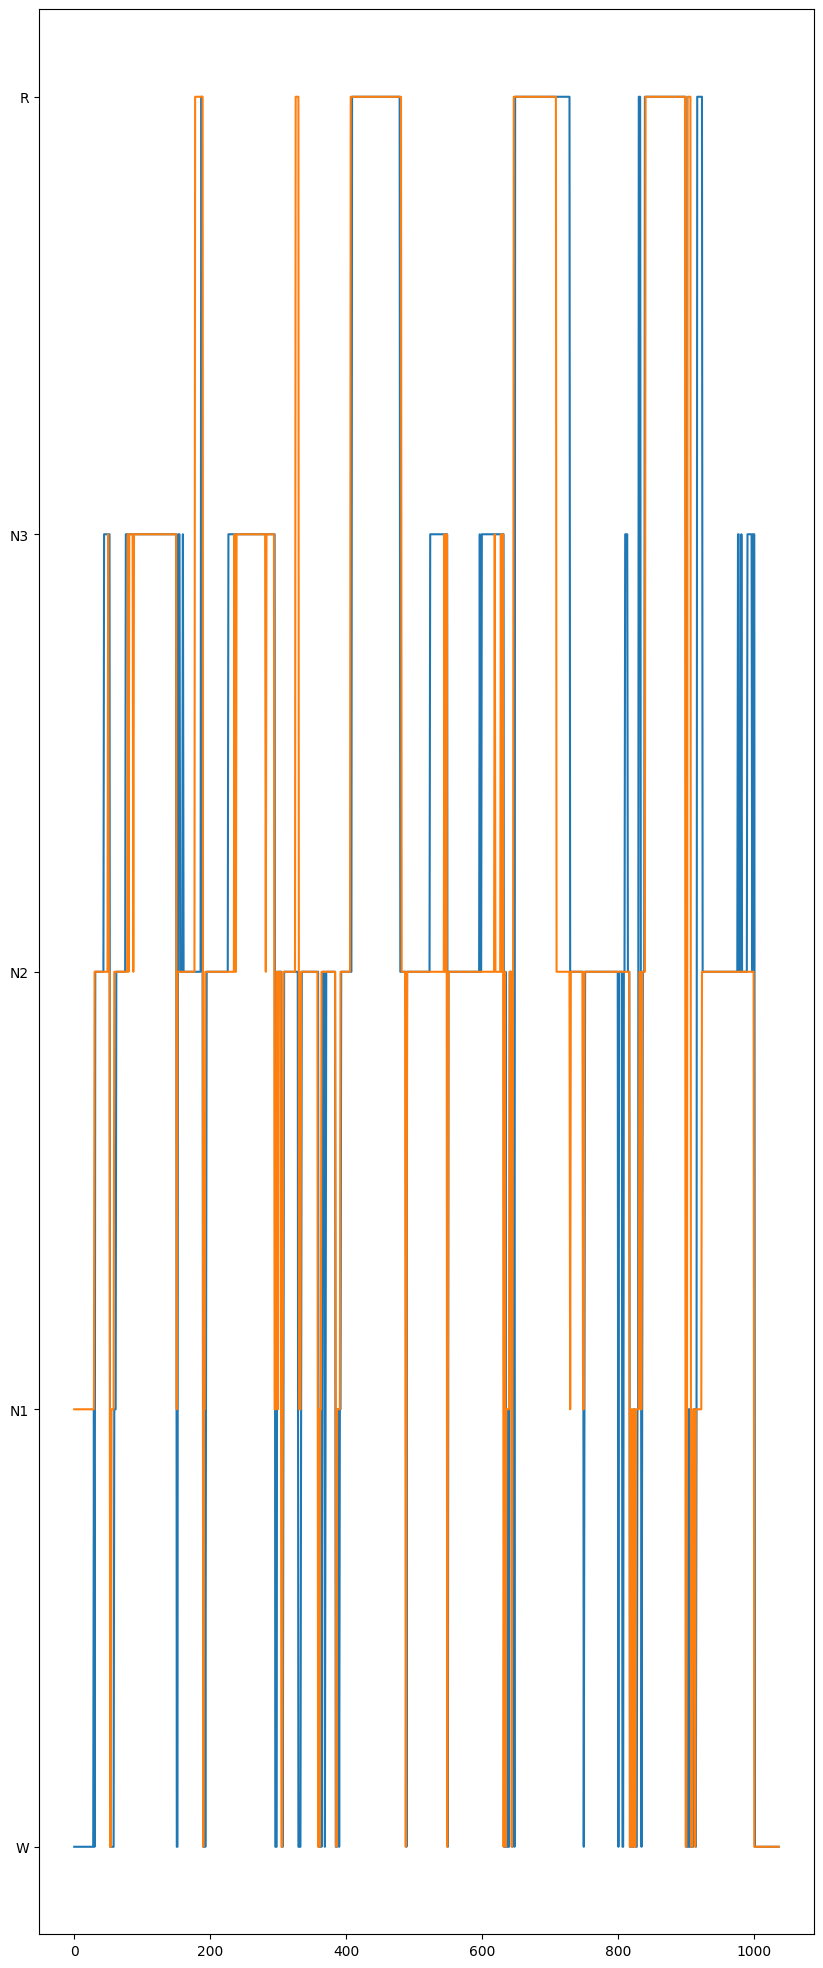

In [285]:
fig,ax=plt.subplots(figsize=(10,25))
ax.plot(y_pred);
ax.plot(hypno);

In [288]:
# What is the accuracy of the prediction, compared to the human scoring
accuracy = (hypno == y_pred).sum() / y_pred.size
print("The overall agreement is %.3f" % accuracy)

The overall agreement is 0.751


**Stage probabilities and confidence of the algorithm at each epoch**

In [289]:
# What are the predicted probabilities of each sleep stage at each epoch?
sls.predict_proba()

,N1,N2,N3,R,W
epoch,,,,,
0,9.448268e-05,9.385937e-06,0.000000e+00,3.495263e-10,0.999896
1,2.942116e-06,5.794615e-07,1.502441e-07,3.075033e-07,0.999996
2,1.743598e-06,1.076777e-06,2.092929e-07,3.278742e-07,0.999997
3,2.123836e-06,1.386609e-06,1.098305e-06,3.508182e-07,0.999995
4,1.180447e-07,2.355057e-07,1.847795e-07,3.698469e-08,0.999999
...,...,...,...,...,...
1033,8.523340e-02,8.695281e-03,2.775634e-04,1.388354e-02,0.891910
1034,5.497345e-02,5.669382e-03,1.105243e-03,1.046337e-02,0.927789
1035,9.011217e-02,7.649372e-03,5.729736e-04,4.201995e-02,0.859646


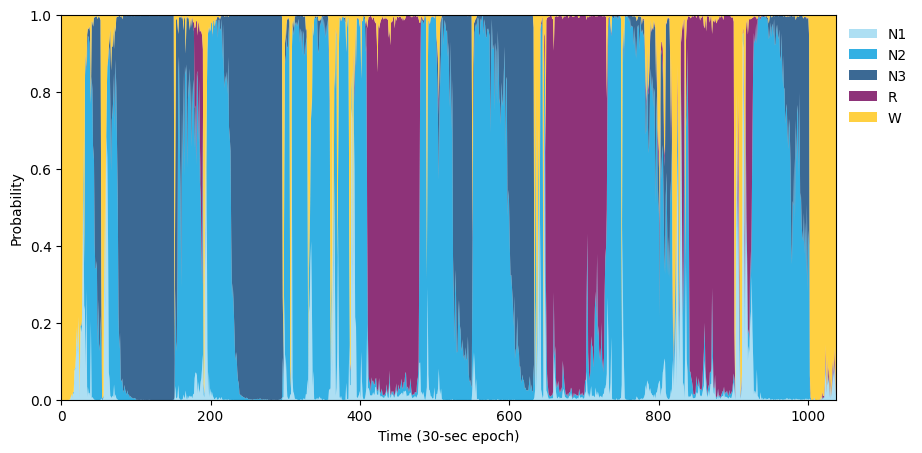

In [141]:
# Plot the predicted probabilities
sls.plot_predict_proba();

In [290]:
# From the probabilities, we can extract a confidence level (ranging from 0 to 1) for each epoch.
confidence = sls.predict_proba().max(1)
confidence

epoch
0       0.999896
1       0.999996
2       0.999997
3       0.999995
4       0.999999
          ...   
1033    0.891910
1034    0.927789
1035    0.859646
1036    0.985094
1037    0.861857
Length: 1038, dtype: float64

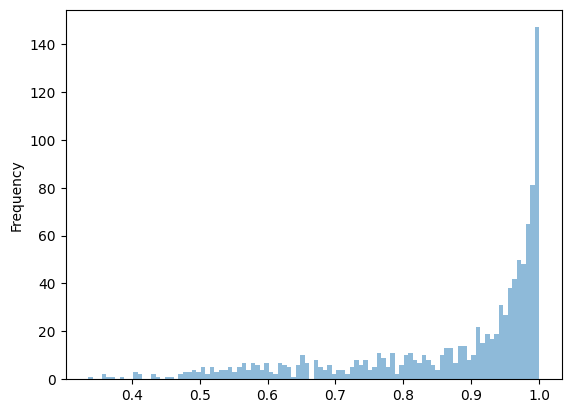

In [293]:
confidence.plot(kind='hist', bins=100, alpha=0.5);

**Exporting to a CSV file**

In [143]:
# Let's first create a dataframe with the predicted stages and confidence
df_pred = pd.DataFrame({'Stage': y_pred, 'Confidence': confidence})
df_pred.head(6)

# Now export to a CSV file
# df_pred.to_csv("my_hypno.csv")

,Stage,Confidence
epoch,,
0,W,0.999896
1,W,0.999996
2,W,0.999997
3,W,0.999995
4,W,0.999999
5,W,1.000000


**Applying the detection using only a single EEG derivation**

In [144]:
# Using just an EEG channel (= no EOG or EMG)
y_pred = yasa.SleepStaging(raw, eeg_name="C4").predict()
y_pred

AssertionError: C4 does not exist